In [1]:
import pandas as pd 
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt 
from collections import defaultdict
%matplotlib inline

In [2]:
df_circuits = pd.read_csv('Formula1_data/circuits.csv')
#Id, reference name, name, loc
df_constructor_results = pd.read_csv('Formula1_data/constructor_results.csv')
#constuctorId, raceId, points
df_constructor_standings = pd.read_csv('Formula1_data/constructor_standings.csv')
#stanidingsId, raceId, constructorId, points, position, wins
df_constructors = pd.read_csv('Formula1_data/constructors.csv')
#id, name, nationality
df_driver_standings = pd.read_csv('Formula1_data/driver_standings.csv')
#id, raceId, driverId, points, position, wins
df_drivers = pd.read_csv('Formula1_data/drivers.csv')
#id, name, number, DOB and other detaiils
df_lap_times = pd.read_csv('Formula1_data/lap_times.csv')
#raceId, DriverID, lap, pooision, time
df_pit_stops = pd.read_csv('Formula1_data/pit_stops.csv')
#raceId, driverID, stop number, time, duration
df_qualifying = pd.read_csv('Formula1_data/qualifying.csv')
#qualiId, raceId, driverId, constructorId, number, position, times (3 qualifying)
df_races = pd.read_csv('Formula1_data/races.csv')
#Id, year, round, circuitId, name, date, time
df_results = pd.read_csv('Formula1_data/results.csv')
#resultId, raceId, driverId, ConstructorId, number, grid, position, position order, points. laps, time, fastest lap time, fastest lap speed
df_status = pd.read_csv('Formula1_data/status.csv')
#statusId, status(finished, dsq, engine issue etc.)

In [3]:
def seasonResults(year):
    df_year = df_races[df_races.year == year]
    race_ids_year = list(df_year.raceId)
    df_year_res = df_results[df_results.raceId.isin(race_ids_year)]
    df_racenames = df_races[df_races.raceId.isin(race_ids_year)]
    df_year_res.reset_index(inplace=True)
    df_year_res.drop(['resultId', 'positionText', 'positionOrder', 'laps'], axis=1, inplace=True)
    df_year_res.drop(['index'], axis=1, inplace=True)

    racenames = defaultdict(str)

    for i in race_ids_year:
        racenames[i] = df_racenames[df_racenames.raceId == i].iloc[0, 4]

    drivers = list(df_year_res.driverId)
    constructors = list(df_year_res.constructorId)
    statii = list(df_year_res.statusId)
    driver_names = defaultdict(str)
    constructor_names = defaultdict(str)
    statii_names = defaultdict(str)
    code_names = defaultdict(str)

    for i in drivers:
        driver_names[i] = df_drivers[df_drivers.driverId == i].iloc[0, 4]+' '+df_drivers[df_drivers.driverId == i].iloc[0, 5]
        code_names[i] = df_drivers[df_drivers.driverId == i].iloc[0, 3]


    for i in constructors:
        constructor_names[i] = df_constructors[df_constructors.constructorId == i].iloc[0, 2]

    for i in statii:
        statii_names[i] = df_status[df_status.statusId == i].iloc[0, 1]

    race = []
    driver = []
    constructor = []
    status = []
    codes = []
    for i in range(len(df_year_res)):
        race.append(racenames[df_year_res.loc[i, 'raceId']])
        driver.append(driver_names[df_year_res.loc[i, 'driverId']])
        constructor.append(constructor_names[df_year_res.loc[i, 'constructorId']])
        status.append(statii_names[df_year_res.loc[i, 'statusId']])
        codes.append(code_names[df_year_res.loc[i, 'driverId']])

    df_year_res['raceName'] = race
    df_year_res['driverName'] = driver
    df_year_res['constructorName'] = constructor
    df_year_res['status'] = status
    df_year_res['code'] = codes
    df_year_res.drop(['raceId', 'driverId', 'constructorId', 'statusId'], axis=1, inplace=True)
    cols = ['raceName', 'constructorName', 'driverName', 'code', 'number', 'grid', 'position', 'points', 'time', 'milliseconds','fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'status']
    df_year_res = df_year_res[cols]

    dc = defaultdict(str)
    codes = list(df_year_res.code.unique())
    const = []
    for i in codes:
        const.append(df_year_res[df_year_res.code == i].iloc[0, 1])

    output = {}
    output['net_results'] = df_year_res
    output['drivers'] = list(df_year_res.driverName.unique())
    output['codes'] = list(df_year_res.code.unique())
    output['constructors'] = const
    output['races'] = list(df_year_res.raceName.unique())

    return output

In [4]:
def cumPoints(driver, year):
    df_year = seasonResults(year)['net_results']
    races = list(df_year.raceName.unique())
    df_dr = df_year[df_year.driverName == driver]
    df_dr_points = list(df_dr.points.cumsum())
    dr_races = list(df_dr.raceName)
    points = defaultdict(lambda :-1)
    for i in range(len(dr_races)):
        points[dr_races[i]] = df_dr_points[i]

    ids = {}
    for i in range(len(races)):
        ids[i] = races[i]

    cp = [0 for i in range(len(races))]
    for i in range(len(races)):
        if points[ids[i]]!=-1:
            cp[i] = points[ids[i]]
        else:
            if i == 0:
                cp[i] = 0
            else:
                cp[i] = cp[i-1]

    return cp

In [5]:
colours = ['#00D2BE', '#C00000', '#FF8700', '#F596C8', '#C8C8C8', '#FFF500', '#960000', '#0082FA', '#0600EF', '#787878']
constructors = list(seasonResults(2020)['net_results'].constructorName.unique())

In [6]:
concol = {}
for i in range(len(constructors)):
    concol[constructors[i]] = colours[i]



In [7]:
def seasonGraph(year):
    annotations = defaultdict(list)
    data = seasonResults(year)
    plt.figure(figsize=[14, 10])

    plt.title('Formula 1 season, '+str(year), fontsize = 20)
    plt.xlabel('Race Name', fontsize = 14)
    plt.ylabel('Points', fontsize = 14)

    for i in range(len(data['drivers'])):
        try:   
            plt.plot(cumPoints(data['drivers'][i], year), label = data['codes'][i], color= concol[data['constructors'][i]])
        except:
            plt.plot(cumPoints(data['drivers'][i], year), label = data['codes'][i])

        annotations[cumPoints(data['drivers'][i], year)[-1]].append(data['codes'][i])
    mod = 1
    for i in annotations.keys():
        annotation = ""
        for j in annotations[i]:
            annotation+=j+","
        annotation+=(" "+str(int(i)))
        
        
        plt.annotate(annotation, (len(data['races']) - 0.8, i))

    '''for i in range(len(data['drivers'])):
        try:
            plt.annotate(data['codes'][i]+', '+str(int(cumPoints(data['drivers'][i], year)[-1])), (len(data['races'])-0.8, cumPoints(data['drivers'][i], year)[-1]), color= concol[data['constructors'][i]])
        except:
            plt.annotate(data['codes'][i]+', '+str(int(cumPoints(data['drivers'][i], year)[-1])), (len(data['races'])-0.8, cumPoints(data['drivers'][i], year)[-1]))'''


    ax = plt.gca()
    ax.set_xticks(range(len(data['races'])))
    ax.set_xticklabels(data['races'], rotation = 75)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.legend()
    plt.show()


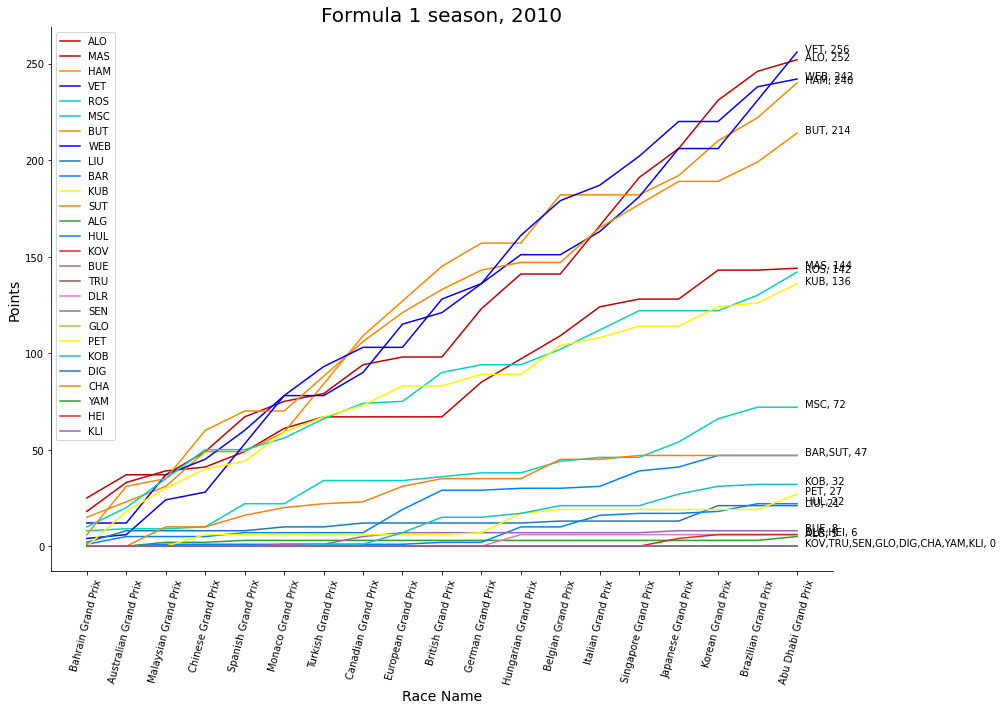

In [8]:
seasonGraph(2010)

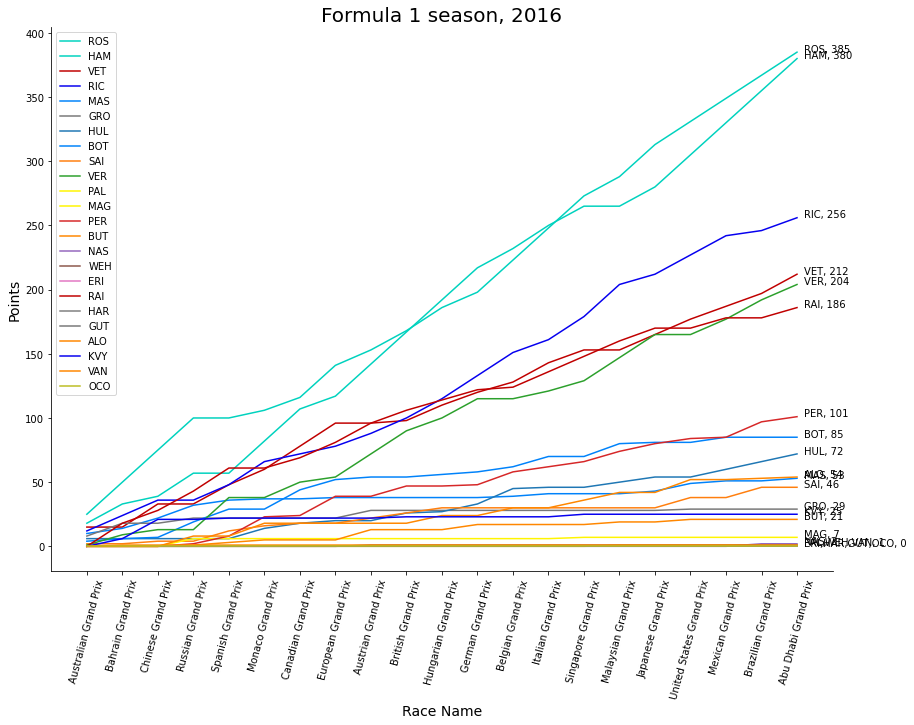

In [9]:
seasonGraph(2016)

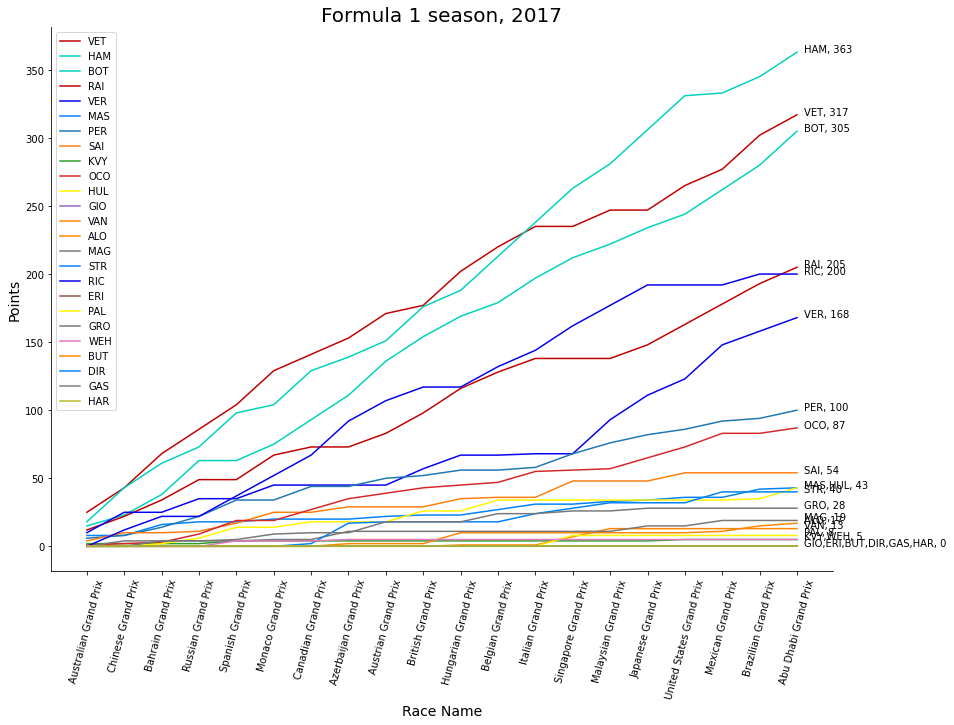

In [10]:
seasonGraph(2017)

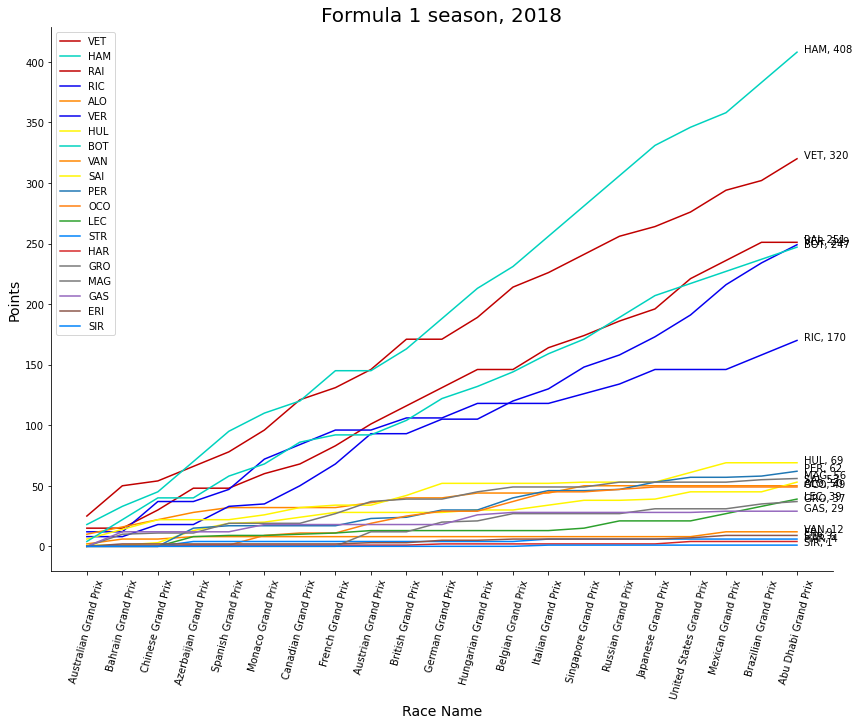

In [11]:
seasonGraph(2018)

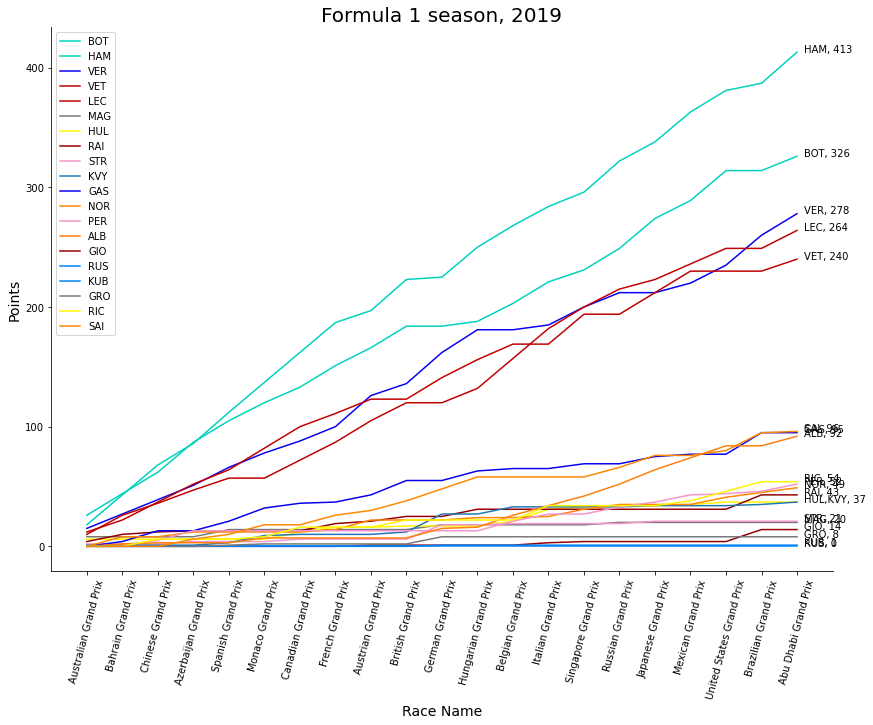

In [12]:
seasonGraph(2019)

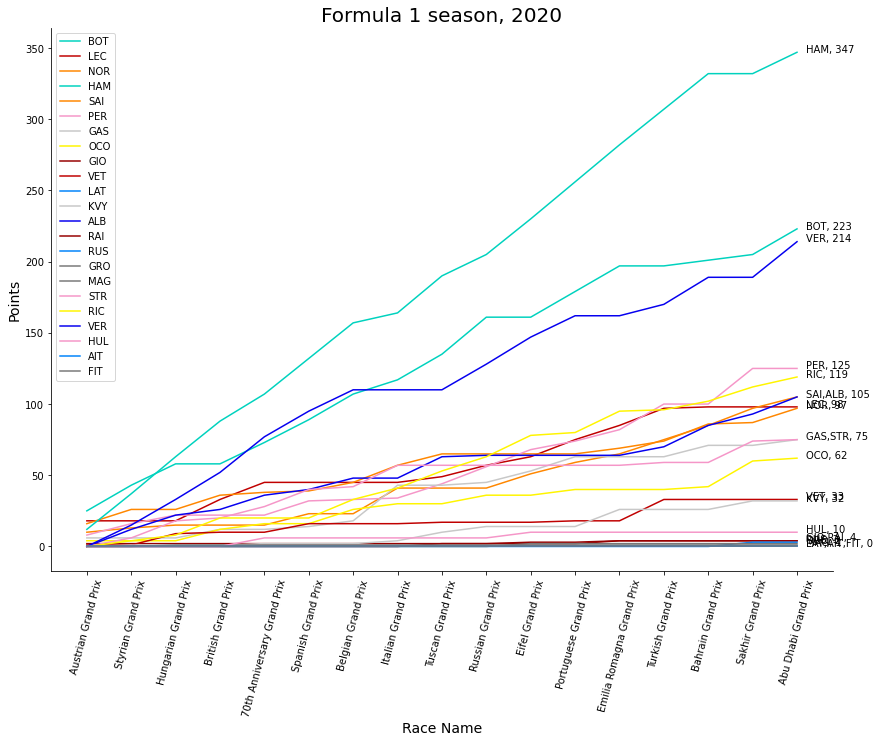

In [13]:
seasonGraph(2020)